PYRAMID BLENDING

In [265]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In order to have laplacian and gaussian pyramid of each image and the mask, first i define methods to resize images from a level to another.I used INTER_AREA mode of resize to avoid noise in laplacian pyramid.By examining many different values i thaught having 3/2 as gap of size in levels has a better result.

In [266]:
def sub_sample(im):
    width = int(im.shape[1]/(3/2))
    height = int(im.shape[0]/(3/2))
    
    new_size = (width, height)
    
    output = cv2.resize(im, new_size,interpolation = cv2.INTER_AREA)
    
    return output

In [267]:
def up_sample(im):
    width = int(im.shape[1]*(3/2))
    height = int(im.shape[0]*(3/2))
    
    new_size = (width, height)
    output = cv2.resize(im, new_size,interpolation = cv2.INTER_AREA)
    
    return output

We want 4 levels of guassian pyramid(to use the smallest level at the end) and 3 levels of laplacian pyramid which is mad by difference of diffrent levels of guassian pyramid as it was told in the course.Here there is methods to build gaussian and laplacian pyramids for input image:

In [268]:
def gauss_pyr(image):
    pyr=[]
    
    level=image
    for k in range(0,4):
        level = cv2.GaussianBlur(level, (1,1), 0)
        level=sub_sample(level)
        
        pyr.append(level)

    return pyr

In [269]:
def laplac_pyr(image,g):
    pyr=[]
    
    for k in range(0,3):
        lvl=up_sample(sub_sample(g[k]))
        l=lvl - up_sample(g[k+1])
        pyr.append(l)
            
    return pyr

As we know we only need a part of image A and imge B which can be defined by convolving a mask on them and also to have a blended result we need to feather the mask before convolving it to images,so here are to methods for feathering mask and applying input mask on input image A and B which are in same levels of different pyramids.

In "feather" method I used guassian blur to have a smooth mask and values that are passed to this smoothing method are decided by examining many different values.

In [270]:
def feather(input_mask):
    m=cv2.GaussianBlur(input_mask, (197,197), cv2.BORDER_CONSTANT)
    m=np.where(input_mask==0,0,m)
    return m

In [271]:
def apply_mask(t,s,mask):
    mask2=feather(mask)
    result = ((1-mask2)*t) + (mask2*s)
    return result

At last we need a pyramid which its level are made by a combination of same level of laplacian pyramid of image A and B.

If we call laplacian of images A and B ,LA and LB respectively and GR be the pyramid of a proper mask, the new pyramid's levels are built by applying same level of GR on LA and LB or in ither words a level of this pyramid is a combination of two images laplacian on that level with a proper mask.

In [272]:
def masked_laplac_pyr(LA,LB,GR):
    pyramid=[]
    
    for k in range(0,3):
        level=apply_mask(LA[k],LB[k],GR[k])
        pyramid.append(level)
    
    return pyramid

By having the combined pyramid and smallest level of guassian pyramids of images we can do the blending by adding gaussian levels and up sampling th result to add a level of "combined pyramid" and again upscaling... until we reach to input image size.

In [273]:
def blend(g1,g2,GR,LA,LB):
    
    m=feather(GR[2])

    g1_maked= (1-m) * (LA[2] + up_sample(g_1[3]))
    g2_masked= (m) * (LB[2] + up_sample(g_2[3]))
   
    s= g1_maked + g2_masked
    
    pyr=masked_laplac_pyr(LA,LB,GR)
    
    p=pyr[1]
    s=up_sample(s)+p
    
    
    p=p[0]
    s=up_sample(s)+p
    
    return s

In [274]:
#loading images
target=cv2.imread('target.jpg')
source=cv2.imread('source.png')

In [275]:
w=source.shape[0]
h=source.shape[1]

h1=142
w1=422

In [276]:
#source in a black matrix with target size
inframe_source=np.zeros(target.shape)
for x in range(0,w-1):
    for y in range(0,h-1):
        if(mask[w1+x][h1+y][0]!=0):
            inframe_source[w1+x][h1+y][0]=source[x][y][0]
            inframe_source[w1+x][h1+y][1]=source[x][y][1]
            inframe_source[w1+x][h1+y][2]=source[x][y][2]

In [277]:
#initializing mask
mask=np.zeros(target.shape)
mask2=np.zeros(source.shape)
mask2=np.where(source==0,0,255)
mask[w1:w1+source.shape[0],h1:h1+source.shape[1],:]=mask2

To get a better mask I used morphology methods of cv2 to "close" mask and after feathering the result I "erode" it because without doing so the result would have some black lines on some edges after up scaling levels of pyramid.

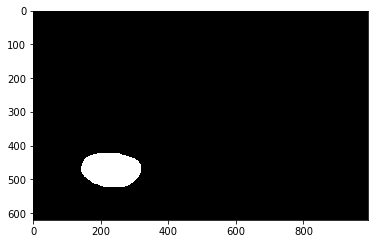

In [278]:
kernel = np.ones((11,11),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(mask)

In [279]:
mask=feather(mask)

In [280]:
kernel = np.ones((5,5),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 1)
mask=mask/255

Now we apply methods on target and source to get result:

In [281]:
g_1=gauss_pyr(target)
g_2=gauss_pyr(inframe_source)

In [282]:
LA=laplac_pyr(target,g_1)
LB=laplac_pyr(inframe_source,g_2)

In [283]:
GR=gauss_pyr(mask)

In [284]:
res = blend(g_1[3],g_2[3],GR,LA,LB)

In [285]:
cv2.imwrite("res2.jpg",res)

True